# Прогнозирование оттока клиентов для «Ниединогоразрыва.ком»

## Описание проекта, цели, задачи

Данный проект реализуется с целью создания модели машинного обучения, способной с достаточным уровнем точности предсказывать факт ухода клиента из вымышленной телеком компании «Ниединогоразрыва.ком». <br>
В течение работы над проектом будут проанализированы 4 набора данных о клиентах компании с информацией о контракте клиента, его персональной ситуации, пользовании услугами телефонии и интернета. Затем будет проведена подготовка данных к машинному обучению, после чего произойдет подбор наиболее подходящей (по метрикам ROC-AUC и accuracy) модели. В итоге работы будет написан отчет.

Среди **целей** проекта следующее:
1. Помощь компании в предотвращении оттока клиентов с помощью его прогнозирования
2. Увеличение прибыли компании в связи с возможностью своевременного реагирования на предсказание ухода (предложение клиенту промокодов и различных специальных условий)
3. Оптимизация бизнес модели компании

**Задачи** проекта таковы:
1. Загрузка данных для дальнейшей работы
2. Исследовательский анализ данных 
3. Подготовка данных для обучения
4. Тестирование моделей обучения и выбор наиболее подходящей модели
5. Проверка модели на тестовой выборке
6. Написание отчета

## Загрузка данных

Приступим к работе. Сперва подключим необходимые в дальнейшем библиотеки:

In [35]:
import os
import pandas as pd
import plotly.graph_objects as go
import phik
from phik.report import plot_correlation_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix

Теперь загрузим данные, приняв в качестве индекса столбец customerID и спарсив даты для датафрейма с информацией о контрактах:

In [36]:
pth1 = '/Users/nikit/Downloads/contract_new.csv'
pth2 = 'contract_new.csv'

if os.path.exists(pth1):
    contract = pd.read_csv(pth1, index_col='customerID', parse_dates=['BeginDate', 'EndDate'])
elif os.path.exists(pth2):
    contract = pd.read_csv(pth2, index_col='customerID', parse_dates=['BeginDate', 'EndDate'])
else:
    print('Что-то пошло не так!')

In [37]:
pth1 = '/Users/nikit/Downloads/personal_new.csv'
pth2 = 'personal_new.csv'

if os.path.exists(pth1):
    personal = pd.read_csv(pth1, index_col='customerID')
elif os.path.exists(pth2):
    personal = pd.read_csv(pth2, index_col='customerID')
else:
    print('Что-то пошло не так!')

In [38]:
pth1 = '/Users/nikit/Downloads/internet_new.csv'
pth2 = 'internet_new.csv'

if os.path.exists(pth1):
    internet = pd.read_csv(pth1, index_col='customerID')
elif os.path.exists(pth2):
    internet = pd.read_csv(pth2, index_col='customerID')
else:
    print('Что-то пошло не так!')

In [39]:
pth1 = '/Users/nikit/Downloads/phone_new.csv'
pth2 = 'phone_new.csv'

if os.path.exists(pth1):
    phone = pd.read_csv(pth1, index_col='customerID')
elif os.path.exists(pth2):
    phone = pd.read_csv(pth2, index_col='customerID')
else:
    print('Что-то пошло не так!')

## Первичный обзор данных

Проведем **первое ознакомление с данными** - получим первые 3 строчки для каждого датасета:

In [40]:
contract.head(3)

BeginDate EndDate            Type PaperlessBilling  \
customerID                                                       
7590-VHVEG 2020-01-01      No  Month-to-month              Yes   
5575-GNVDE 2017-04-01      No        One year               No   
3668-QPYBK 2019-10-01      No  Month-to-month              Yes   

               PaymentMethod  MonthlyCharges TotalCharges  
customerID                                                 
7590-VHVEG  Electronic check           29.85        31.04  
5575-GNVDE      Mailed check           56.95      2071.84  
3668-QPYBK      Mailed check           53.85       226.17

In [41]:
personal.head(3)

gender  SeniorCitizen Partner Dependents
customerID                                          
7590-VHVEG  Female              0     Yes         No
5575-GNVDE    Male              0      No         No
3668-QPYBK    Male              0      No         No

In [42]:
internet.head(3)

InternetService OnlineSecurity OnlineBackup DeviceProtection  \
customerID                                                                
7590-VHVEG             DSL             No          Yes               No   
5575-GNVDE             DSL            Yes           No              Yes   
3668-QPYBK             DSL            Yes          Yes               No   

           TechSupport StreamingTV StreamingMovies  
customerID                                          
7590-VHVEG          No          No              No  
5575-GNVDE          No          No              No  
3668-QPYBK          No          No              No

In [43]:
phone.head(3)

MultipleLines
customerID              
5575-GNVDE            No
3668-QPYBK            No
9237-HQITU            No

## Обзор типов, пропусков, дубликатов

Данные выглядят ожидаемым образом. На беглый взгляд каких-то неясных признаков или путающих значений не видно. Теперь посмотрим **более полную информацию о наборах данных**:

In [44]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   object        
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 440.2+ KB


Набор данных о контракте содержит 6 категориальных признаков и 1 количественный. Отметим, что признак TotalCharges, судя по всему, тоже должен быть количественным. На следующем этапе работы предстоит привести его тип к числовому (float64). 

In [45]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   int64 
 2   Partner        7043 non-null   object
 3   Dependents     7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB


Видим, что в датасете с персональными данными 4 признака категориальные, 1 - количественный, хотя по существу признак SeniorCitizen так же является категориальным.

In [46]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   InternetService   5517 non-null   object
 1   OnlineSecurity    5517 non-null   object
 2   OnlineBackup      5517 non-null   object
 3   DeviceProtection  5517 non-null   object
 4   TechSupport       5517 non-null   object
 5   StreamingTV       5517 non-null   object
 6   StreamingMovies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB


В случае набора с данными об интернет подключении все 8 признаков являются категориальными.

In [47]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MultipleLines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB


Данные о телефонной связи также записаны категорильно для 2 признаков.

В целом можем отметить отсутствие пропусков во всех 4 датасетах. Также похоже, что многие категориальные признаки в дальнейшем можно будет закодировать числами 0 и 1 (в основном те, которые содержат значения Yes и No). Более точно разберемся с этим с помощью **анализа распределения**.

Напоследок проверим данные на наличие **дубликатов** по клиентскому id (его мы используем в качестве индекса):

In [48]:
contract.index.is_unique

True

In [49]:
personal.index.is_unique

True

In [50]:
internet.index.is_unique

True

In [51]:
phone.index.is_unique

True

Как видим, все 4 датасета свободны от дубликатов.

## Анализ распределения признаков

Начнем анализ с признака **Type** в данных о контракте, содержащем информацию о типе оплаты. Будем анализировать долю соответствующих контрактов с помощью гистограммы, которую удобно использовать для подобного рода анализа категориальных признаков. 

In [52]:
fig = go.Figure(data=[go.Histogram(x=contract['Type'], histnorm='probability')])
fig.update_layout(
    title_text='Распределение клиентов по типам',
    xaxis_title_text='Тип контракта',
    yaxis_title_text='Доля клиентов'
)
fig.show()

Видим, что больше половины (55%) всех наблюдаемых контрактов являются ежемесячными. Кроме них, имеем примерно равное количество годовых (21%) и двухгодовых (24%) контрактов. Видим некоторую несбалансированность классов, которую важно учитывать для корректного обучения.

Теперь исследуем распределение для признака **PaperlessBilling**, говорящего о том, является ли платежный документ электронным или нет:

In [53]:
fig = go.Figure(data=[go.Histogram(x=contract['PaperlessBilling'], histnorm='probability')])
fig.update_layout(
    title_text='Распределение клиентов по наличию электронного платежного документа',
    xaxis_title_text='Наличие электронного платежного документа',
    yaxis_title_text='Доля клиентов'
)
fig.show()

Как видно на гистограмме, 59% контрактов подразумевают электронный платежный документ, 41% - нет. Здесь классы практически соразмерны. В то же время, не похоже, чтобы информация, передаваемая этим признаком, была бы полезная для прогнозирования ухода клиента.

Теперь рассмотрим распределение признака **PaymentMethod**, который несет информацию о способе оплаты:

In [54]:
fig = go.Figure(data=[go.Histogram(x=contract['PaymentMethod'], histnorm='probability')])
fig.update_layout(
    title_text='Распределение клиентов по способу платежа',
    xaxis_title_text='Способ платежа',
    yaxis_title_text='Доля клиентов'
)
fig.show()

Можем видеть, что большая часть контрактов (34%) оплачиваются с помощью электронного чека. Далее, примерно в равных долях, встречаются чеки, отправленные почтой (23%), автоматические банковские переводы (22%) и автоматическая оплата кредитной картой (22%). В этом случае так же возникает подозрение в необходимости этих данных для предсказания клиентского оттока. 

Далее, исследуем распределение значений для признака **MonthlyCharges**, содержащего данные о ежемесячных тратах, используя для этого "ящик с усами", в котором точками отдельно покажем выбросы:

In [55]:
fig = go.Figure(data=[go.Box(y=contract['MonthlyCharges'],
            boxpoints='outliers', name='MonthlyCharges')])
fig.update_layout(
    title_text='Распределение клиентов по сумме ежемесячных трат',
    xaxis_title_text='Сумма ежемесячных трат'
)
fig.show()

Как видим, в данных вообще нет выборосов, медианное значение ежемесячных трат на услуги составляет 70.35, минимальное значение - 18.25, максимальное - 118.75. 

Взглянем на признак **TotalCharges**, который говорит об общей сумме средств, потраченных на услуги:

In [56]:
fig = go.Figure(data=[go.Box(y=contract['TotalCharges'],
            boxpoints='outliers', name='TotalCharges')])
fig.update_layout(
    title_text='Распределение клиентов по суммарным тратам на услуги',
    xaxis_title_text='Сумма трат'
)
fig.show()

Этот признак также не хранит в себе примеров-выбросов. Медианная сумма общих трат составляется 1256.54, минимальная - 31.04, максимальная - 7251.82. 

Налицо большая разница в размахе данных для двух количественных признаков в датафрейме contract. Это стоит учесть в следующих этапах. 

Продолжим анализом распределения признака **gender**, содержащего информацию о гендере клиента, в наборе с персональной информацией о клиентах:

In [57]:
fig = go.Figure(data=[go.Histogram(x=personal['gender'], histnorm='probability')])
fig.update_layout(
    title_text='Распределение клиентов по гендеру',
    xaxis_title_text='Гендер',
    yaxis_title_text='Доля клиентов'
)
fig.show()

Видим почти идеальный баланс распределения клиентов, в обоих случаях доля клиентов соответствующего гендера находится в районе 50%.

Рассмотрим распределения признака **SeniorCitizen**, показывающего, является ли клиент пенсионером по возрасту:

In [58]:
fig = go.Figure(data=[go.Histogram(x=personal['SeniorCitizen'], histnorm='probability')])
fig.update_layout(
    title_text='Распределение клиентов по пенсионному статусу',
    xaxis_title_text='Пенсионный статус',
    yaxis_title_text='Доля клиентов'
)
fig.show()

Из данных следует, что 84% клиентов не являются пенсионерами по возрасту, оставшиеся 16% - являются. Вновь можно говорить о сомнениях в важности этого признака в прогнозировании ухода клиента. 

Теперь проанализируем распределение признака **Partner**, он говорит нам о наличии супруг_и:

In [59]:
fig = go.Figure(data=[go.Histogram(x=personal['Partner'], histnorm='probability')])
fig.update_layout(
    title_text='Распределение клиентов по наличию или отсутствию супруг_и',
    xaxis_title_text='Наличие супруг_и',
    yaxis_title_text='Доля клиентов'
)
fig.show()

Клиенты разделились почти поровну - у 48% партнер_ка есть, у 52% - нет. Снова сложно представить, что этот признак может влиять на уход клиента. Аргументом может быть разве что большая консервативность в принятии подобных решений семейными парами. В то же время, люди в целом как будто не склонны импульсивно или частно менять своих телеком-провайдеров. 

На очереди признак **Dependents**, который сообщает о наличии иждевенцев, зависящих от клиента:

In [60]:
fig = go.Figure(data=[go.Histogram(x=personal['Dependents'], histnorm='probability')])
fig.update_layout(
    title_text='Распределение клиентов по наличию или отсутствию иждивенцев',
    xaxis_title_text='Наличие иждевенцев',
    yaxis_title_text='Доля клиентов'
)
fig.show()

Можем заключить, что большая часть (70%) клиентов компании не имеет живущих на их попечении людей. 30% клиентов такими людьми обладает. 

Продолжим анализом распределения признака **InternetService**, который говорит о типе интернет-подключения:

In [61]:
fig = go.Figure(data=[go.Histogram(x=internet['InternetService'], histnorm='probability')])
fig.update_layout(
    title_text='Распределение клиентов по типу интернет-подключения',
    xaxis_title_text='Тип интернет-подключения',
    yaxis_title_text='Доля клиентов'
)
fig.show()

Можем сделать вывод о том, что 44% клиентов используют DSL, остальные 56% - оптоволоконный кабель. 

Теперь взглянем на распределение для признака **OnlineSecurity**, который говорит о том, подключена ли у клиента услуга блокировки небезопасных сайтов:

In [62]:
fig = go.Figure(data=[go.Histogram(x=internet['OnlineSecurity'], histnorm='probability')])
fig.update_layout(
    title_text='Распределение клиентов по услуге блокировки небезопасных сайтов',
    xaxis_title_text='Наличие услуги блокировки',
    yaxis_title_text='Доля клиентов'
)
fig.show()

Можем видеть, что большинство клиентов (63%) услугой блокировки небезопасных сайтов не пользуются. Остальные 37% данную услугу подключили. 

Взглянем на распределение признака **OnlineBackup**, сообщающего, использует ли клиент облачное хранилище для резервного копирования данных:

In [63]:
fig = go.Figure(data=[go.Histogram(x=internet['OnlineBackup'], histnorm='probability')])
fig.update_layout(
    title_text='Распределение клиентов по использованию облачного хранилища для резервного копирования данных',
    xaxis_title_text='Пользование облачным резервным копированием',
    yaxis_title_text='Доля клиентов'
)
fig.show()

Можем видеть более сбалансированное вокруг 50% распределение. 44% клиентов облачное хранилище для резервного копирования используют, 56% - нет. 

Рассмотрим распределение признака **DeviceProtection**, который говорит, пользуется ли клиент антивирусом:

In [64]:
fig = go.Figure(data=[go.Histogram(x=internet['DeviceProtection'], histnorm='probability')])
fig.update_layout(
    title_text='Распределение клиентов по использованию антивируса',
    xaxis_title_text='Пользование антивирусом',
    yaxis_title_text='Доля клиентов'
)
fig.show()

Распределение напомнинает предыдущее. 56% клиентов услугой антивируса не пользуются, пользуется ей 44% клиентов. 

Теперь проанализируем распределение для признака **TechSupport**, сообщающей, пользуется ли клиент выделенной линией тех. поддержки:

In [65]:
fig = go.Figure(data=[go.Histogram(x=internet['TechSupport'], histnorm='probability')])
fig.update_layout(
    title_text='Распределение клиентов по использованию выделенной линией технической поддержки',
    xaxis_title_text='Пользование выделенной линией',
    yaxis_title_text='Доля клиентов'
)
fig.show()

Отметим, что 63% выделенной линией тех. поддержки не пользуются, пользуются данной услугой 37% клиентов. 

Посмотрим на распределение признака **StreamingTV**, он содержит информацию о том, подключено ли у клиента стриминговое телевидение:

In [66]:
fig = go.Figure(data=[go.Histogram(x=internet['StreamingTV'], histnorm='probability')])
fig.update_layout(
    title_text='Распределение клиентов по подключению стримингового телевидения',
    xaxis_title_text='Пользование стриминговым телевиденим',
    yaxis_title_text='Доля клиентов'
)
fig.show()

Снова встречаем равное распределение - не пользуется стриминг-телевидением 51% клиентов, пользуется - 49%.

Проанализируем распределение признака **StreamingMovies**, он несет информацию о том, подключен ли у клиента каталог фильмов:

In [67]:
fig = go.Figure(data=[go.Histogram(x=internet['StreamingMovies'], histnorm='probability')])
fig.update_layout(
    title_text='Распределение клиентов по подключению каталога фильмов',
    xaxis_title_text='Подключение каталога фильмов',
    yaxis_title_text='Доля клиентов'
)
fig.show()

Снова данные разделяются поровну. Подключен каталог фильмов у 50% клиентов, не подключен также у 50%.

Наконец проанализируем распределение признака **MultipleLines**, который говорит о наличии возможности ведения параллельных линий во время звонка:

In [68]:
fig = go.Figure(data=[go.Histogram(x=phone['MultipleLines'], histnorm='probability')])
fig.update_layout(
    title_text='Распределение клиентов по возможности использования параллельных линий',
    xaxis_title_text='Возможность использования параллельных линий',
    yaxis_title_text='Доля клиентов'
)
fig.show()

Распределение почти равное. 47% клиентов имеют услугу, позволяющую им пользоваться параллельными линиями, 35% - нет.

В случае с услугами представляется целесообразным использовать для обучения все признаки. Вероятно, отток происходит из-за того, что какая-то услуга предоставляется на недостаточном уровне, в связи с чем подключившие ее клиенты могут решить уйти из компании. 

## Подготовка данных

Начнем готовить данные с датасета **contract**. Сперва **приведем названия столбцов к змеиному стилю**:

In [69]:
contract.rename(columns={'BeginDate':'begin_date', 'EndDate':'end_date', 
                           'Type':'type', 'PaperlessBilling':'paperless_billing', 'PaymentMethod':'payment_method',
                           'MonthlyCharges':'monthly_charges', 'TotalCharges':'total_charges'}, inplace = True)
contract.index.names = ['customer_id']

Удостоверимся в том, что изменение названий прошло успешно:

In [70]:
contract.head(0)

Empty DataFrame
Columns: [begin_date, end_date, type, paperless_billing, payment_method, monthly_charges, total_charges]
Index: []

Теперь **займемся приведением типов**. Изменим тип признака total_charges на числовой. Сперва проработаем ситуацию, в которой значением для этого признака является пробел (' '):

In [71]:
contract.query('total_charges == " "')

begin_date end_date      type paperless_billing  \
customer_id                                                   
4472-LVYGI  2020-02-01       No  Two year               Yes   
3115-CZMZD  2020-02-01       No  Two year                No   
5709-LVOEQ  2020-02-01       No  Two year                No   
4367-NUYAO  2020-02-01       No  Two year                No   
1371-DWPAZ  2020-02-01       No  Two year                No   
7644-OMVMY  2020-02-01       No  Two year                No   
3213-VVOLG  2020-02-01       No  Two year                No   
2520-SGTTA  2020-02-01       No  Two year                No   
2923-ARZLG  2020-02-01       No  One year               Yes   
4075-WKNIU  2020-02-01       No  Two year                No   
2775-SEFEE  2020-02-01       No  Two year               Yes   

                        payment_method  monthly_charges total_charges  
customer_id                                                            
4472-LVYGI   Bank transfer (automatic)            52.55                
3115-CZMZD                Mailed check            20.25                
5709-LVOEQ                Mailed check            80.85                
4367-NUYAO                Mailed check            25.75                
1371-DWPAZ     Credit card (automatic)            56.05                
7644-OMVMY                Mailed check            19.85                
3213-VVOLG                Mailed check            25.35                
2520-SGTTA                Mailed check            20.00                
2923-ARZLG                Mailed check            19.70                
4075-WKNIU                Mailed check            73.35                
2775-SEFEE   Bank transfer (automatic)            61.90

Как видим, все клиенты с таким значением начали сотрудничать с компанией 1 февраля 2020 - дата на которую актуальна информация о договорах. Судя по всему, суммарные траты на этот момент еще не были рассчитаны. Будем использовать в их качестве соответствующее значение признака monthly_charges, чего достигнем с помощью написания лямбда-выражения:

In [72]:
contract['total_charges'] = contract.apply(lambda x: x['monthly_charges'] 
                                           if x['total_charges'] == ' ' 
                                           else x['total_charges'], axis=1)

Проверим успешность обработки пропущенного значения:

In [73]:
contract.query('total_charges == " "')

Empty DataFrame
Columns: [begin_date, end_date, type, paperless_billing, payment_method, monthly_charges, total_charges]
Index: []

Теперь приведем признак к типу float:

In [74]:
contract['total_charges'] = contract['total_charges'].astype('float')

Удостоверимся в том, что теперь в датафрейме contract типы данных удовлетворяют их смыслу:

In [75]:
contract.dtypes

begin_date           datetime64[ns]
end_date                     object
type                         object
paperless_billing            object
payment_method               object
monthly_charges             float64
total_charges               float64
dtype: object

Займемся приведением типов для таблицы **personal**. Приведем названия столбцов к нужному стилю:

In [76]:
personal.rename(columns={'SeniorCitizen':'senior_citizen', 'Partner':'partner', 
                         'Dependents':'dependents'}, inplace = True)
personal.index.names = ['customer_id']

Проверим результат:

In [77]:
personal.head(0)

Empty DataFrame
Columns: [gender, senior_citizen, partner, dependents]
Index: []

Датасетам **internet** и **phone** дополнительное приведение типов не потребуется. Так что просто приведем названия столбцов к "змеиному" стилю:

In [78]:
internet.rename(columns={'InternetService':'internet_service', 'OnlineSecurity':'online_security', 
                         'OnlineBackup':'online_backup', 'DeviceProtection':'device_protection',
                         'TechSupport':'tech_support', 'StreamingTV':'streaming_tv',
                         'StreamingMovies':'streaming_movies'}, inplace = True)
internet.index.names = ['customer_id']

Посмотрим на результат:

In [79]:
internet.head(0)

Empty DataFrame
Columns: [internet_service, online_security, online_backup, device_protection, tech_support, streaming_tv, streaming_movies]
Index: []

In [80]:
phone.rename(columns={'MultipleLines':'multiple_lines'}, inplace = True)
phone.index.names = ['customer_id']

Посмотрим на результат:

In [81]:
phone.head(0)

Empty DataFrame
Columns: [multiple_lines]
Index: []

Теперь соединим все датафреймы в одну таблицу с помощью инструмента join:

In [82]:
df = contract.join([personal, internet, phone])

Взглянем на результат:

In [83]:
df.head(3)

begin_date end_date            type paperless_billing  \
customer_id                                                         
7590-VHVEG  2020-01-01       No  Month-to-month               Yes   
5575-GNVDE  2017-04-01       No        One year                No   
3668-QPYBK  2019-10-01       No  Month-to-month               Yes   

               payment_method  monthly_charges  total_charges  gender  \
customer_id                                                             
7590-VHVEG   Electronic check            29.85          31.04  Female   
5575-GNVDE       Mailed check            56.95        2071.84    Male   
3668-QPYBK       Mailed check            53.85         226.17    Male   

             senior_citizen partner dependents internet_service  \
customer_id                                                       
7590-VHVEG                0     Yes         No              DSL   
5575-GNVDE                0      No         No              DSL   
3668-QPYBK                0      No         No              DSL   

            online_security online_backup device_protection tech_support  \
customer_id                                                                
7590-VHVEG               No           Yes                No           No   
5575-GNVDE              Yes            No               Yes           No   
3668-QPYBK              Yes           Yes                No           No   

            streaming_tv streaming_movies multiple_lines  
customer_id                                               
7590-VHVEG            No               No            NaN  
5575-GNVDE            No               No             No  
3668-QPYBK            No               No             No

Посмотрим, все ли записи оказались в нашей таблице:

In [84]:
df.shape[0]

7043

Все 7043 записи на месте.

Сформулируем целевой признак **left**. Если клиент ушел из компании, присвоим ему значение 1, если нет - 0.

In [85]:
df['left'] = [0 if x =='No' else 1 for x in df['end_date']]

Проверим результат:

In [86]:
df[['end_date', 'left']].sample(3)

end_date  left
customer_id                  
7594-RQHXR           No     0
3528-HFRIQ   2016-05-01     1
9700-ISPUP           No     0

Видим, что целевой признак ведет себя предсказуемым образом. Проверим как соотносятся классы целевого признака:

In [87]:
df['left'].value_counts(normalize=True)

0    0.843675
1    0.156325
Name: left, dtype: float64

Можем засвидетельствовать **дисбаланс классов**. Из клиентов в нашем датафрейма покинули фирму 16%, не покинули - 84%. Стоит помнить об этом на этапе машинного обучения.

Создадим новый признак - число дней, которые клиент провел в компании. Для этого сперва заменим в признаке end_date значение No на 01.02.2020 (дата, на которую актуальны данные в таблице):

In [88]:
df['end_date'] = df['end_date'].replace({'No': '2020-02-01'})

Посмотрим на результат:

In [89]:
df.head(3)

begin_date    end_date            type paperless_billing  \
customer_id                                                            
7590-VHVEG  2020-01-01  2020-02-01  Month-to-month               Yes   
5575-GNVDE  2017-04-01  2020-02-01        One year                No   
3668-QPYBK  2019-10-01  2020-02-01  Month-to-month               Yes   

               payment_method  monthly_charges  total_charges  gender  \
customer_id                                                             
7590-VHVEG   Electronic check            29.85          31.04  Female   
5575-GNVDE       Mailed check            56.95        2071.84    Male   
3668-QPYBK       Mailed check            53.85         226.17    Male   

             senior_citizen partner dependents internet_service  \
customer_id                                                       
7590-VHVEG                0     Yes         No              DSL   
5575-GNVDE                0      No         No              DSL   
3668-QPYBK                0      No         No              DSL   

            online_security online_backup device_protection tech_support  \
customer_id                                                                
7590-VHVEG               No           Yes                No           No   
5575-GNVDE              Yes            No               Yes           No   
3668-QPYBK              Yes           Yes                No           No   

            streaming_tv streaming_movies multiple_lines  left  
customer_id                                                     
7590-VHVEG            No               No            NaN     0  
5575-GNVDE            No               No             No     0  
3668-QPYBK            No               No             No     0

Посмотрим на типы данных в признаках с датами:

In [90]:
df[['begin_date', 'end_date']].dtypes

begin_date    datetime64[ns]
end_date              object
dtype: object

Видим, что признак begin_date уже приведен к нужному типу (мы спарсили его значения как дату на этапе загрузки данных), теперь приведем к типу datetime признак end_date:

In [91]:
df['end_date'] = pd.to_datetime(df['end_date'], format='%Y-%m-%d')

Удостоверимся, что тип признака был успешно изменен:

In [92]:
df[['end_date']].dtypes

end_date    datetime64[ns]
dtype: object

Теперь добавим в датафрейм новый признак time_in_company, несущий информацию о количестве дней клиента в компании, - разность между признаками end_date и begin_date:

In [93]:
df['time_in_company'] = df['end_date'] - df['begin_date']

Посмотрим на результат:

In [94]:
df[['begin_date', 'end_date', 'time_in_company']].sample(3)

begin_date   end_date time_in_company
customer_id                                      
2990-HWIML  2019-07-01 2019-09-01         62 days
2495-TTHBQ  2019-10-01 2020-02-01        123 days
8129-GMVGI  2015-06-01 2020-02-01       1706 days

In [95]:
df[['begin_date', 'end_date', 'time_in_company']].dtypes

begin_date          datetime64[ns]
end_date            datetime64[ns]
time_in_company    timedelta64[ns]
dtype: object

Видим, что у признака time_in_company тип timedelta. Переведем его в integer:

In [96]:
df['time_in_company'] = df['time_in_company'].dt.days

Проверим успешность преобразования:

In [97]:
df[['time_in_company']].dtypes

time_in_company    int64
dtype: object

Взглянем на основную информацию о таблице:

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           7043 non-null   datetime64[ns]
 2   type               7043 non-null   object        
 3   paperless_billing  7043 non-null   object        
 4   payment_method     7043 non-null   object        
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7043 non-null   float64       
 7   gender             7043 non-null   object        
 8   senior_citizen     7043 non-null   int64         
 9   partner            7043 non-null   object        
 10  dependents         7043 non-null   object        
 11  internet_service   5517 non-null   object        
 12  online_security    5517 non-null   object        
 13  online_backup      5517 non-null   object        
 14

Видим наличие пропусков в признаках internet_service, online_security, online_backup, device_protection, tech_support, streaming_tv, streaming_movies и multiple_lines. Пропуски эти связаны с тем, что не все клиенты пользуются одновременно и интернетом и телефонной связью. Можем видеть, что интернет подключен у 5517 клиентов, телефонная связь - у 6361. На месте таких пропусков поставим "заглушку" - строку 'No':

In [100]:
df=df.fillna('No')

Проверим, что теперь наш датафрейм не содержит пропусков:

In [101]:
df.isna().sum().sum()

0

In [102]:
df.head()

begin_date   end_date            type paperless_billing  \
customer_id                                                           
7590-VHVEG  2020-01-01 2020-02-01  Month-to-month               Yes   
5575-GNVDE  2017-04-01 2020-02-01        One year                No   
3668-QPYBK  2019-10-01 2020-02-01  Month-to-month               Yes   
7795-CFOCW  2016-05-01 2020-02-01        One year                No   
9237-HQITU  2019-09-01 2020-02-01  Month-to-month               Yes   

                        payment_method  monthly_charges  total_charges  \
customer_id                                                              
7590-VHVEG            Electronic check            29.85          31.04   
5575-GNVDE                Mailed check            56.95        2071.84   
3668-QPYBK                Mailed check            53.85         226.17   
7795-CFOCW   Bank transfer (automatic)            42.30        1960.60   
9237-HQITU            Electronic check            70.70         353.50   

             gender  senior_citizen partner  ... internet_service  \
customer_id                                  ...                    
7590-VHVEG   Female               0     Yes  ...              DSL   
5575-GNVDE     Male               0      No  ...              DSL   
3668-QPYBK     Male               0      No  ...              DSL   
7795-CFOCW     Male               0      No  ...              DSL   
9237-HQITU   Female               0      No  ...      Fiber optic   

            online_security online_backup device_protection tech_support  \
customer_id                                                                
7590-VHVEG               No           Yes                No           No   
5575-GNVDE              Yes            No               Yes           No   
3668-QPYBK              Yes           Yes                No           No   
7795-CFOCW              Yes            No               Yes          Yes   
9237-HQITU               No            No                No           No   

            streaming_tv streaming_movies multiple_lines left  time_in_company  
customer_id                                                                     
7590-VHVEG            No               No             No    0               31  
5575-GNVDE            No               No             No    0             1036  
3668-QPYBK            No               No             No    0              123  
7795-CFOCW            No               No             No    0             1371  
9237-HQITU            No               No             No    0              153  

[5 rows x 21 columns]

Также сразу отметим, что для дальнейшего обучения нам не понадобятся признаки begin_date и end_date, так как наша задача не связана с анализом/прогнозированием временных рядов. Удалим соответствующие признаки:

In [103]:
df.drop(['begin_date', 'end_date'], axis=1, inplace=True)

Уточним, что эти признаки действительно пропали из общего списка признаков:

In [104]:
df.columns

Index(['type', 'paperless_billing', 'payment_method', 'monthly_charges',
       'total_charges', 'gender', 'senior_citizen', 'partner', 'dependents',
       'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'multiple_lines', 'left', 'time_in_company'],
      dtype='object')

Теперь **исследуем корреляцию** с помощью корреляционной матрицы:

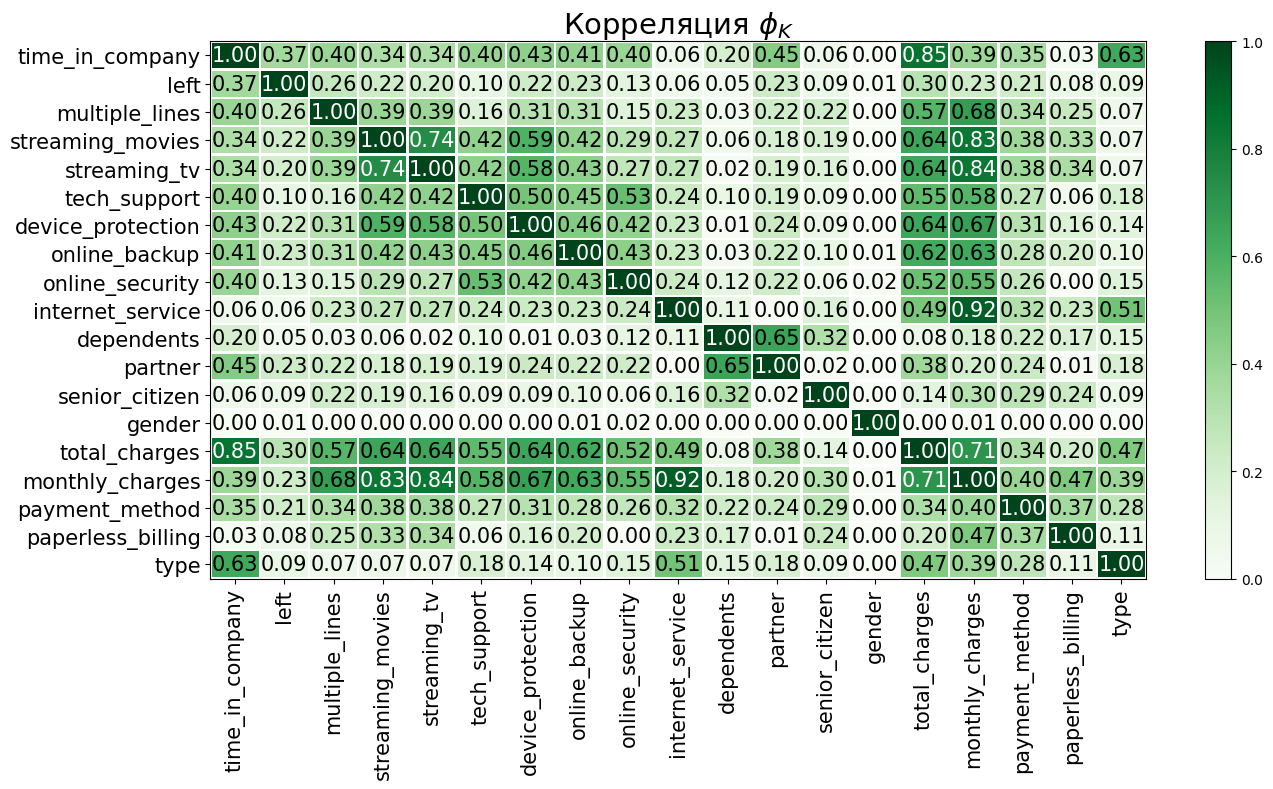

In [105]:
interval_cols = ['monthly_charges', 'total_charges', 'time_in_company']
phik_overview = df.phik_matrix(interval_cols=interval_cols)
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"Корреляция $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(14, 8))
plt.tight_layout()

Видим большую корреляцию (0.85) между признаками time_in_company и total_charges, связь просматривается достаточно прозрачно - длительность пребывания клиента в компании влияет на общую сумму его трат на услуги компании. Удалим из этих двух признаков тот, что меньше скоррелирован с целевым признаком. time_im_company коррелирует с left на 0.37, total_charges - 0.30. Удаляем признак total_charges:

In [106]:
df.drop('total_charges', axis=1, inplace=True)

Проверим успешность удаления:

In [107]:
'total_charges' in df.columns

False

Заметим также большую корреляцию (0.83) между признаками monthly_charges и streaming_movies. Вероятно, услуга кино-стриминга составляет в месячных тратах достаточно большое место, если она подключена. Руководствуясь тем же принципом, что и на предыдущем шаге, удалим признак streaming_movies:

In [108]:
df.drop('streaming_movies', axis=1, inplace=True)

In [109]:
'streaming_movies' in df.columns

False

Похожая корреляция (0.84) у признака monthly_charges с признаком streaming_tv, причина так же видится сходной. Удалим признак streaming_tv:

In [110]:
df.drop('streaming_tv', axis=1, inplace=True)

In [111]:
'streaming_tv' in df.columns

False

Тот же признак monthly_charges сильно коррелирует с признаком internet_service. Судя по всему, от выбора типа интернет-подключения сильно зависит месячный ценник. Удалим internet_service:

In [112]:
df.drop('internet_service', axis=1, inplace=True)

In [113]:
'internet_service' in df.columns

False

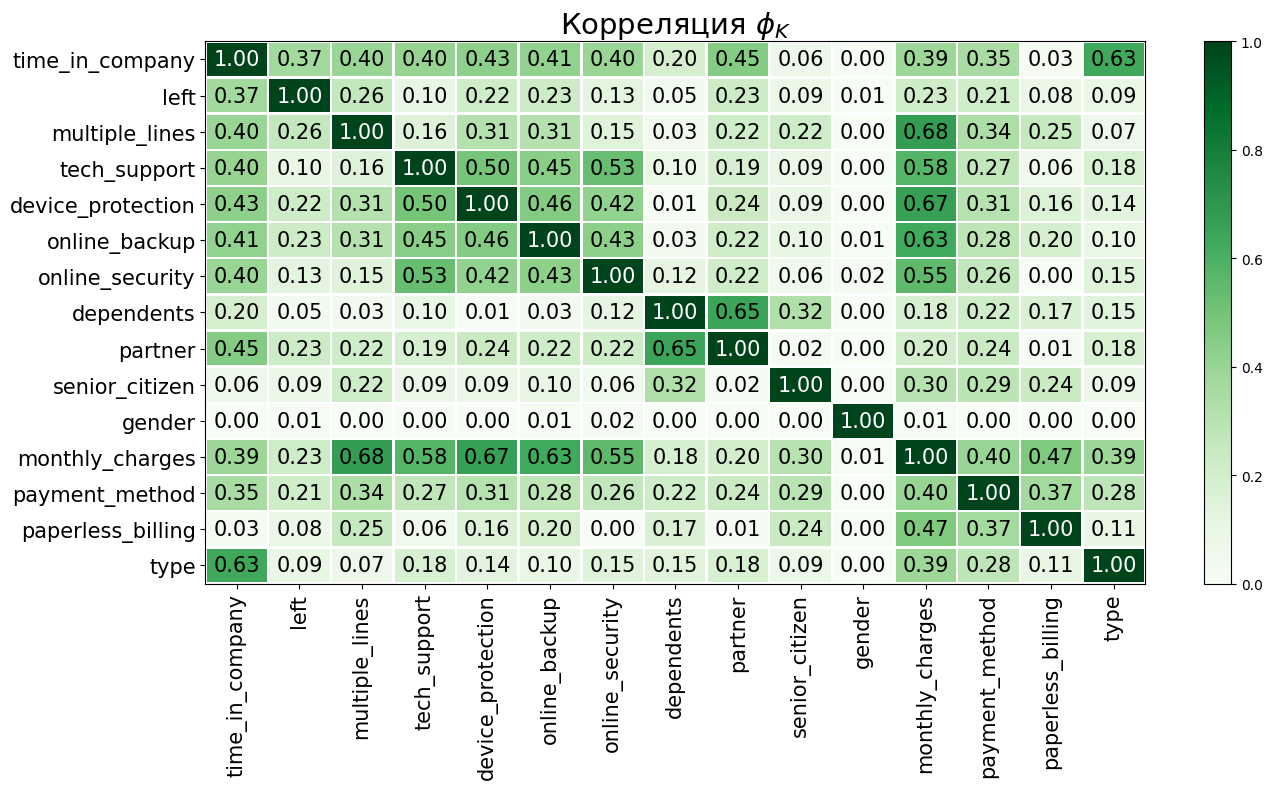

In [114]:
interval_cols = ['monthly_charges', 'time_in_company']
phik_overview = df.phik_matrix(interval_cols=interval_cols)
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"Корреляция $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(14, 8))
plt.tight_layout()

Больше сильно скоррелированных между собой признаков не наблюдается.

В целом, отметим заметную скоррелированность между признаками, отвечающими за услуги интернета и телефонии, и признаками ежемесячных и общих трат. Это представляется логичным - количество подключенных услуг влияет на затраты клиента. Так же заметна связь между признаками time_in_company и type (0.63) - время клиента в компании вполне может зависить от периодичности его контракта (ежемесячного, годового или двухгодичного). Кроме того, видна связь между признаками partner и dependents (0.65) - наличие супруг_и и наличие зависящих лиц вполне обоснованно (например, такими лицами могут быть дети). 

Наконец, создаим два списка для названий категориальных и количественных переменных. Сперва взглянем на типы данных, использующиеся в нашем датафрейме для записи каждого признака:

In [115]:
df.dtypes

type                  object
paperless_billing     object
payment_method        object
monthly_charges      float64
gender                object
senior_citizen         int64
partner               object
dependents            object
online_security       object
online_backup         object
device_protection     object
tech_support          object
multiple_lines        object
left                   int64
time_in_company        int64
dtype: object

Создадим список категориальных признаков, не забыв добавить туда признак senior_citizen:

In [116]:
cat_features = df.select_dtypes(include='object').columns.to_list()
cat_features.append('senior_citizen')
cat_features

['type',
 'paperless_billing',
 'payment_method',
 'gender',
 'partner',
 'dependents',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'multiple_lines',
 'senior_citizen']

Теперь создадим список количественных признаков:

In [117]:
num_features = ['monthly_charges', 'time_in_company']
num_features

['monthly_charges', 'time_in_company']

## Обучение моделей

На этом этапе проведем обучение моделей машинного обучения. Порогом успеха будем считать значение метрики ROC-AUC не меньше 0.85.

Для использование в следующих частях зададим random_state:

In [118]:
RANDOM_STATE = 240423

Разделим данные на тренировочную и тестовую выборку в пропорции 3:1:

In [119]:
features = df.drop(['left'], axis=1)
target = df['left']


features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE
)

Посмотрим на размеры получившихся выборок:

In [120]:
features_train.shape, target_train.shape

((5282, 14), (5282,))

In [121]:
features_test.shape, target_test.shape

((1761, 14), (1761,))

Начнем с **масштабирования числовых признаков**. Масштабированные признаки будем использовать во всех моделях, поэтому преобразовывать будем выборку features_train.

Создадим шкалировщик:

In [122]:
scaler = StandardScaler()

Обучим его на тренировочных данных и сразу их преобразуем:

In [123]:
features_train[num_features] = scaler.fit_transform(features_train[num_features])

Посмотрим на получившийся набор:

In [124]:
features_train[num_features].head(3)

monthly_charges  time_in_company
customer_id                                  
7552-KEYGT         -1.504902        -0.109133
7569-NMZYQ          1.792493         0.068306
1666-JZPZT         -0.525988        -0.109133

Теперь **закодируем категориальные признаки** для обучения логистической регрессии и случайного леса. Так как бустинговую модель будем обучать по изначальным данным, кодировку будем проводить на копиях тренировочной выборки. Также скопируем тестовую выборку на случай, если эти модели покажут наилучший результат: 

In [125]:
features_train_ohe = features_train.copy()
features_test_ohe = features_test.copy()

Удостоверимся в успешности копирования:

In [126]:
features_train_ohe.shape, features_test_ohe.shape

((5282, 14), (1761, 14))

Создадим OHE кодировщик для преобразования категориальных признаков для обучения логистической регрессии и случайного леса:

In [127]:
encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

Обучим его на категориальных признака тренировочной выборки:

In [128]:
encoder.fit(features_train_ohe[cat_features])

OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

Трансформируем категориальные признаки и удалим изначальные столбцы:

In [129]:
features_train_ohe[encoder.get_feature_names_out()] = encoder.transform(features_train_ohe[cat_features])

In [130]:
features_train_ohe = features_train_ohe.drop(cat_features, axis=1)

Посмотрим на вид получившейся выборки и ее размер:

In [131]:
features_train_ohe.head(3)

monthly_charges  time_in_company  type_One year  type_Two year  \
customer_id                                                                   
7552-KEYGT         -1.504902        -0.109133            0.0            1.0   
7569-NMZYQ          1.792493         0.068306            0.0            1.0   
1666-JZPZT         -0.525988        -0.109133            0.0            0.0   

             paperless_billing_Yes  payment_method_Credit card (automatic)  \
customer_id                                                                  
7552-KEYGT                     0.0                                     0.0   
7569-NMZYQ                     1.0                                     0.0   
1666-JZPZT                     0.0                                     0.0   

             payment_method_Electronic check  payment_method_Mailed check  \
customer_id                                                                 
7552-KEYGT                               0.0                          0.0   
7569-NMZYQ                               0.0                          0.0   
1666-JZPZT                               0.0                          1.0   

             gender_Male  partner_Yes  dependents_Yes  online_security_Yes  \
customer_id                                                                  
7552-KEYGT           1.0          1.0             0.0                  0.0   
7569-NMZYQ           0.0          1.0             1.0                  1.0   
1666-JZPZT           1.0          0.0             0.0                  0.0   

             online_backup_Yes  device_protection_Yes  tech_support_Yes  \
customer_id                                                               
7552-KEYGT                 0.0                    0.0               0.0   
7569-NMZYQ                 1.0                    1.0               1.0   
1666-JZPZT                 0.0                    0.0               0.0   

             multiple_lines_Yes  senior_citizen_1  
customer_id                                        
7552-KEYGT                  0.0               0.0  
7569-NMZYQ                  1.0               0.0  
1666-JZPZT                  1.0               0.0

In [132]:
features_train_ohe.shape

(5282, 17)

Теперь от масштабирования и кодирования признаков перейдем непосредственно к **машинному обучению**:

Процесс обучения начнем с **логистической регрессии**:

In [133]:
model = LogisticRegression(random_state=RANDOM_STATE)

Проведем кросс-валидацию модели:

In [134]:
scores = cross_val_score(model, features_train_ohe, target_train, scoring='roc_auc', cv=3, n_jobs=-1, verbose=10)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s finished


In [135]:
print(scores)
print(scores.mean())

[0.76068577 0.73350726 0.74638293]
0.7468586560256054


Как видим, среднее значение метрики (0.75) не удовлетворяет условию. Попробуем провести подбор гиперпараметров:

In [136]:
distributions = dict(C=uniform(loc=0, scale=4), 
                     max_iter=range(500, 1500, 50))
clf = RandomizedSearchCV(model, distributions, n_iter=50, scoring='roc_auc', n_jobs=-1, 
                         verbose=10, random_state=RANDOM_STATE)

In [137]:
search = clf.fit(features_train_ohe, target_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [138]:
print(search.best_score_)
print(search.best_params_)

0.7467515116464145
{'C': 0.21901348753289485, 'max_iter': 550}


Видим, что подбор гиперпараметров не помог сильно увеличить значение метрики, которое в результате подбора так же оказалось равным 0.75. 

Обучим модель **случайного леса**:

In [139]:
model = RandomForestClassifier(random_state=RANDOM_STATE)

In [140]:
scores = cross_val_score(model, features_train_ohe, target_train, scoring='roc_auc', cv=3, n_jobs=-1)

In [141]:
print(scores)
print(scores.mean())

[0.80143791 0.78148865 0.8039336 ]
0.7956200549368783


Видим несколько лучшее значение метрики (0.8). Попробуем усовершенствовать его с помощью подбора гиперпараметров:

In [142]:
distributions = dict(n_estimators=range(10, 300, 10), 
                     max_depth=[None] + [i for i in range(2, 11)])
clf = RandomizedSearchCV(model, distributions, n_iter=50, scoring='roc_auc', n_jobs=-1, 
                         verbose=10, random_state=RANDOM_STATE)

In [143]:
search = clf.fit(features_train_ohe, target_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [144]:
print(search.best_score_)
print(search.best_params_)

0.8232438101424421
{'n_estimators': 80, 'max_depth': 8}


Значение метрики несколько улучшилось (0.82), но все еще не дотягивает до необходимого порога. 

Обучим **LGBMClassifier**. Для обучения будем использовать features_train, так как данный классификатор умеет справляться с незакодированными категориальными признаками. Для начала приведем категориальные признаки к типу category:

In [145]:
features_train[cat_features] = features_train[cat_features].astype('category')

Проверим успешность преобразования:

In [146]:
features_train[cat_features].dtypes

type                 category
paperless_billing    category
payment_method       category
gender               category
partner              category
dependents           category
online_security      category
online_backup        category
device_protection    category
tech_support         category
multiple_lines       category
senior_citizen       category
dtype: object

In [147]:
model = LGBMClassifier(
    boosting_type='gbdt',
    num_leaves=31,
    max_depth=-1,
    learning_rate=0.1,
    n_estimators=100,
    objective='binary',
    min_split_gain=0.0,
    min_child_samples=20,
    subsample=1.0,
    subsample_freq=0,
    colsample_bytree=1.0,
    reg_alpha=0.0,
    reg_lambda=0.0,
    random_state=None
)

In [148]:
scores = cross_val_score(model, features_train, target_train, scoring='roc_auc', cv=3, n_jobs=-1, verbose=10)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.7s finished


In [149]:
print(scores)
print(scores.mean())

[0.86781283 0.83742666 0.85424893]
0.8531628065376342


Видим, что модель дала нужное значение метрики - 0.85. Попробуем поднять его с помощью подбора гиперпараметров:

In [150]:
distributions = dict(n_estimators=range(150, 300, 10), 
                     max_depth=[None] + [i for i in range(2, 11)],
                     learning_rate=[0.01, 0.05, 0.1],)
clf = RandomizedSearchCV(model, distributions, n_iter=50, scoring='roc_auc', n_jobs=-1,
                         verbose=10, random_state=RANDOM_STATE)

In [151]:
search = clf.fit(features_train, target_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [152]:
print(search.best_score_)
print(search.best_params_)

0.8896296812747575
{'n_estimators': 280, 'max_depth': 5, 'learning_rate': 0.1}


Получили еще несколько большее значение метрики - 0.89. Можем сказать, что **лучшая модель - LGBMClassifier**.

## Тестирование лучшей модели

Создадим финальную модель с необходимыми параметрами:

In [153]:
final_model = LGBMClassifier(
    boosting_type='gbdt',
    num_leaves=31,
    max_depth=5,
    learning_rate=0.1,
    n_estimators=280,
    objective='binary',
    class_weight='balanced',
    min_split_gain=0.0,
    min_child_samples=20,
    subsample=1.0,
    subsample_freq=0,
    colsample_bytree=1.0,
    reg_alpha=0.0,
    reg_lambda=0.0,
    random_state=None
)

Обучим ее на тренировочной выборке:

In [154]:
final_model.fit(features_train, target_train)

LGBMClassifier(class_weight='balanced', max_depth=5, n_estimators=280,
               objective='binary')

Не забудем промасштабировать количественные признаки в тестовой выборке и привести типы к category:

In [155]:
features_test[num_features] = scaler.transform(features_test[num_features])

Проверим результат:

In [156]:
features_test[num_features].head(3)

monthly_charges  time_in_company
customer_id                                  
4534-WGCIR         -1.318759         1.276656
2362-IBOOY          0.662338        -0.557865
5115-SQAAU         -1.303801         1.767914

In [157]:
features_test[cat_features] = features_test[cat_features].astype('category')

Проверим результат:

In [158]:
features_test[cat_features].dtypes

type                 category
paperless_billing    category
payment_method       category
gender               category
partner              category
dependents           category
online_security      category
online_backup        category
device_protection    category
tech_support         category
multiple_lines       category
senior_citizen       category
dtype: object

Теперь предскажем вероятности для классов:

In [159]:
target_predicted_proba = final_model.predict_proba(features_test)

Подсчитаем метрику ROC-AUC:

In [160]:
roc_auc_score(target_test, target_predicted_proba[:, 1])

0.9075131390964839

Предскажем сами классы:

In [161]:
target_predicted = final_model.predict(features_test)

Посчитаем метрику Accuracy:

In [162]:
accuracy_score(target_test, target_predicted)

0.8750709823963657

На тестовых данных получили значения метрик **ROC-AUC** в **0.91**, **Accuracy** - **0.88**.

Сравним нашу модель с дамми-классификатором, который всегда будем предсказывать самое частое значение в тренировочной целевой выборке(в нашем случае - 0):

In [163]:
dummy_clf = DummyClassifier(strategy='most_frequent')

Обучим дамми-классификатор на тренировочных данных:

In [164]:
dummy_clf.fit(features_train, target_train)

DummyClassifier(strategy='most_frequent')

Предскажем вероятности и классы для тестового набора признаков:

In [165]:
dummy_predicted_proba = dummy_clf.predict_proba(features_test)
dummy_predicted = dummy_clf.predict(features_test)

Посчитаем метрики ROC-AUC и Accuracy:

In [166]:
roc_auc_score(target_test, dummy_predicted_proba[:, 1])

0.5

In [167]:
accuracy_score(target_test, dummy_predicted)

0.8534923339011925

Видим, что дамми-модель показала гораздо более низкое значение по метрике ROC-AUC (0.5) и схожее значение по метрике Accuracy (0.85). 

Для более точного анализа построим **confusion matrix** (с абсолютными значениями и нормализованную) для нашей модели:

In [168]:
confusion_matrix(target_test, target_predicted)

array([[1346,  157],
       [  63,  195]], dtype=int64)

In [169]:
confusion_matrix(target_test, target_predicted, 
                 normalize='all')

array([[0.76433844, 0.08915389],
       [0.03577513, 0.11073254]])

Как видим, наша модель верно определила как оставшихся 1346 (76%) клиентов, а как ушедших 195 (11%). Ошибочно предсказала 157 (9%) клиентов как ушедших и 63 (4%) как оставшихся. То есть модель предсказывает уход клиента, который на самом деле остался, чаще, чем неуход клиента, который на самом деле собирается уйти. 

Проанализируем **важность признаков**:

In [171]:
feature_importance = pd.DataFrame(data={'feature_importance':final_model.feature_importances_}, 
                                  index=final_model.feature_name_)
feature_importance.index.name = 'feature'
feature_importance = feature_importance.sort_values(by='feature_importance', ascending=False)
feature_importance

feature_importance
feature                              
time_in_company                  2467
monthly_charges                  1506
type                              269
partner                           166
gender                            130
dependents                        126
multiple_lines                    124
device_protection                 114
paperless_billing                 108
online_backup                     106
payment_method                     86
online_security                    86
tech_support                       70
senior_citizen                     57

Визуализируем важность признаков с помощью столбчатой диаграммы:

In [172]:
fig = go.Figure(data=[go.Bar(x=feature_importance.index, y=feature_importance['feature_importance'])])
fig.update_layout(title_text='Важность признаков для лучшей модели')
fig.show()

Можем заключить, что самой большой важностью (2467) для предсказания ухода клиента обладает признак time_in_company, несущий информацию о числе дней, которые человек был клиентом компании, вторым с довольно большой разницей идет признак monthly_charges (1506). Заметно меньшая важность (269) у признака type, который говорит о типе оплаты (ежемесячный, ежегодный, двухгодичный). Остальные признаки имеют важность меньше 167, а самым маловажным признаком является senior_citizen со значением 57. <br>
По двум главным по важности признакам можем заключить, что важнее всего для прогнозирования ухода знать, сколько времени человек является клиентом компании и какова сумма его месячных платежей. Остальные признаки ощутимо меньше влияют на уход. 

**Результат проведенной работы можем считать удовлетворительным** в связи с преодолением искомого порога в 0.85 для метрики ROC-AUC.